In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier



In [66]:
titanic_train = pd.read_csv('data/train.csv')
titanic_test = pd.read_csv('data/test.csv')


In [67]:
titanic_train


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Step 1: Handling data before applying DataMining Features

#### 1.1 Drop Columns with no relevant information

we dropped the following:

- PassengerId : useless numbering of passengers
- Name : String value that has no effect
- Ticket : String value that has no effect
- Cabin : String value that has no effect


In [68]:
titanic_train.drop(columns=['PassengerId', 'Name',
                   'Ticket', 'Cabin'], inplace=True)


titanic_test.drop(columns=['PassengerId', 'Name',
                   'Ticket', 'Cabin'], inplace=True)


#### 1.2 Dropping rows with NaN values

the reason: Features in this DataBase are too important to auto-fill


In [69]:
for col in titanic_train.columns:
    titanic_train.dropna(inplace=True)


for col in titanic_test.columns:
    titanic_test.dropna(inplace=True)


In [70]:
titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


#### 1.3 Binning Sex attribute

- male : {0}
- female : {1}


In [71]:
titanic_train['Sex'] = titanic_train['Sex'].map({'male': 0, 'female': 1})
titanic_test['Sex'] = titanic_test['Sex'].map({'male': 0, 'female': 1})

titanic_train



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,Q
886,0,2,0,27.0,0,0,13.0000,S
887,1,1,1,19.0,0,0,30.0000,S
889,1,1,0,26.0,0,0,30.0000,C


#### 1.4 converting the categorical feature 'Embarked' into numerical labels


In [72]:
label_encoder = LabelEncoder()
titanic_train['Embarked'] = label_encoder.fit_transform(
    titanic_train['Embarked'])

titanic_test['Embarked'] = label_encoder.fit_transform(
    titanic_test['Embarked'])



In [73]:
titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,0
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,1
886,0,2,0,27.0,0,0,13.0000,2
887,1,1,1,19.0,0,0,30.0000,2
889,1,1,0,26.0,0,0,30.0000,0


### Step 2: Pre-Processing


#### 2.1: Normalization

using MinMaxScaler function


In [74]:
numerical_cols = titanic_train.columns.drop('Survived')


norm_scaler = MinMaxScaler()
titanic_train[numerical_cols] = norm_scaler.fit_transform(
    titanic_train[numerical_cols])


titanic_test[numerical_cols] = norm_scaler.fit_transform(
    titanic_test[numerical_cols])

#### 2.2 Standarization

using StandardScaler function


In [75]:
scaler_std = StandardScaler()
titanic_train[numerical_cols] = scaler_std.fit_transform(
    titanic_train[numerical_cols])

titanic_test[numerical_cols] = scaler_std.fit_transform(
    titanic_test[numerical_cols])

titanic_train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0.908600,-0.756138,-0.527669,0.522511,-0.506787,-0.516380,0.519588
1,1,-1.482983,1.322511,0.577094,0.522511,-0.506787,0.694046,-2.049487
2,1,0.908600,1.322511,-0.251478,-0.552714,-0.506787,-0.503620,0.519588
3,1,-1.482983,1.322511,0.369951,0.522511,-0.506787,0.350326,0.519588
4,0,0.908600,-0.756138,0.369951,-0.552714,-0.506787,-0.501257,0.519588
...,...,...,...,...,...,...,...,...
885,0,0.908600,1.322511,0.646142,-0.552714,5.350885,-0.102875,-0.764949
886,0,-0.287191,-0.756138,-0.182430,-0.552714,-0.506787,-0.407687,0.519588
887,1,-1.482983,1.322511,-0.734812,-0.552714,-0.506787,-0.086335,0.519588
889,1,-1.482983,-0.756138,-0.251478,-0.552714,-0.506787,-0.086335,-2.049487


In [76]:
titanic_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.015426,-0.789018,0.306657,-0.553272,-0.492120,-0.542281,-0.508681
1,1.015426,1.267399,1.194236,0.591310,-0.492120,-0.555844,0.652515
2,-0.168046,-0.789018,2.259331,-0.553272,-0.492120,-0.511885,-0.508681
3,1.015426,-0.789018,-0.225890,-0.553272,-0.492120,-0.528651,0.652515
4,1.015426,1.267399,-0.580922,0.591310,0.741907,-0.469357,0.652515
...,...,...,...,...,...,...,...
409,1.015426,1.267399,-1.930042,0.591310,0.741907,-0.445026,0.652515
411,-1.351518,1.267399,0.484173,0.591310,-0.492120,0.801785,-0.508681
412,1.015426,1.267399,-0.154884,-0.553272,-0.492120,-0.543168,0.652515
414,-1.351518,1.267399,0.626186,-0.553272,-0.492120,1.110932,-1.669877


### Step 3: Selection Features - Recursive feature selection


#### 3.1: LogisticRegression


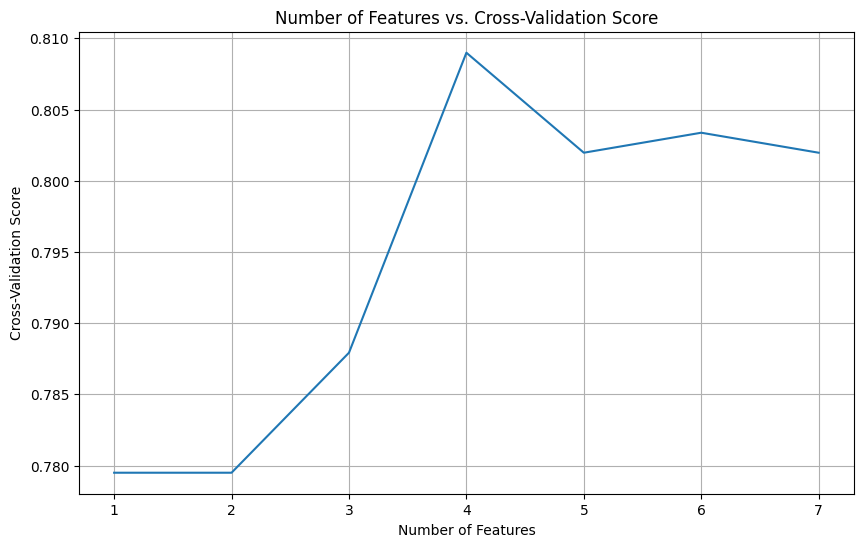

Optimal number of features: 4
Selected features: Index(['Pclass', 'Sex', 'Age', 'SibSp'], dtype='object')


In [77]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


X_train = titanic_train.drop(columns=['Survived'])
y_train = titanic_train['Survived']
y_test = titanic_train['Survived']



number_of_features = range(1, len(X_train.columns) + 1)
estimator = LogisticRegression()
scores = []
selected_features_list = []


for i in number_of_features:
    rfe = RFE(estimator, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    selected_features_list.append(selected_features)
    scores.append(rfe.score(X_train, y_train))


plt.figure(figsize=(10, 6))
plt.plot(number_of_features, scores)
plt.title('Number of Features vs. Cross-Validation Score')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score')
plt.xticks(number_of_features)
plt.grid(True)
plt.show()

best_index = scores.index(max(scores))
best_num_features = number_of_features[best_index]
best_selected_features = selected_features_list[best_index]

print("Optimal number of features:", best_num_features)
print("Selected features:", best_selected_features)


#### 3.2 Random Forest Classifier


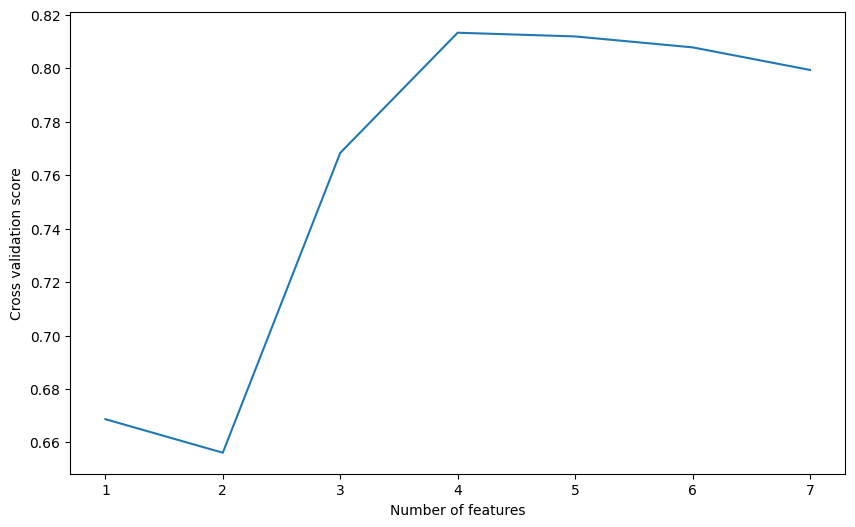

Optimal number of features: 4
Selected features: Index(['Pclass', 'Sex', 'Age', 'Fare'], dtype='object')


In [78]:

estimator = RandomForestClassifier(n_estimators=100)
rfecv = RFECV(estimator=estimator, step=1,
              cv=StratifiedKFold(10), scoring='accuracy')

rfecv.fit(X_train, y_train)


plt.figure(figsize=(10, 6))
plt.xlabel("Number of features")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_[
         'mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

print("Optimal number of features: {}".format(rfecv.n_features_))
selected_features = X_train.columns[rfecv.support_]
print("Selected features:", selected_features)


In [79]:
X_train.drop(columns=['SibSp', 'Parch', 'Embarked'],inplace=True)


X_train

,Pclass,Sex,Age,Fare
0,0.908600,-0.756138,-0.527669,-0.516380
1,-1.482983,1.322511,0.577094,0.694046
2,0.908600,1.322511,-0.251478,-0.503620
3,-1.482983,1.322511,0.369951,0.350326
4,0.908600,-0.756138,0.369951,-0.501257
...,...,...,...,...
885,0.908600,1.322511,0.646142,-0.102875
886,-0.287191,-0.756138,-0.182430,-0.407687
887,-1.482983,1.322511,-0.734812,-0.086335
889,-1.482983,-0.756138,-0.251478,-0.086335


In [80]:
X_test = copy.deepcopy(titanic_test)
X_test.drop(columns=['SibSp', 'Parch', 'Embarked'],inplace=True)


X_test

,Pclass,Sex,Age,Fare
0,1.015426,-0.789018,0.306657,-0.542281
1,1.015426,1.267399,1.194236,-0.555844
2,-0.168046,-0.789018,2.259331,-0.511885
3,1.015426,-0.789018,-0.225890,-0.528651
4,1.015426,1.267399,-0.580922,-0.469357
...,...,...,...,...
409,1.015426,1.267399,-1.930042,-0.445026
411,-1.351518,1.267399,0.484173,0.801785
412,1.015426,1.267399,-0.154884,-0.543168
414,-1.351518,1.267399,0.626186,1.110932


### Step 4: Featurtes Extraction

In [81]:
from sklearn.decomposition import PCA


pca = PCA(n_components=4)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


### Step 5: Testing accuaracy with diffrent classifiers


##### SVC

In [82]:
classifier = SVC()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_train_pca)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the classifier is: {accuracy}')

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       424
           1       0.89      0.65      0.75       288

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.81       712
weighted avg       0.84      0.83      0.82       712

The accuracy of the classifier is: 0.8258426966292135


#### RandomForest

In [83]:
classifier = RandomForestClassifier()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_train_pca)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the classifier  is: {accuracy}')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       424
           1       1.00      0.97      0.98       288

    accuracy                           0.98       712
   macro avg       0.99      0.98      0.98       712
weighted avg       0.98      0.98      0.98       712

The accuracy of the classifier  is: 0.9845505617977528


#### LogisticRegression

In [84]:
classifier = LogisticRegression()
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_train_pca)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the classifier is: {accuracy}')


              precision    recall  f1-score   support

           0       0.82      0.84      0.83       424
           1       0.76      0.72      0.74       288

    accuracy                           0.79       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.79      0.79      0.79       712

The accuracy of the classifier is: 0.7921348314606742
